# R2 Authentification

In [1]:
endpoint_url_secret = "https://xxxxxxxxxxxxxxxx.r2.cloudflarestorage.com"
aws_access_key_id_secret = "xxxxxxxxxxxxxxxxxxx"
aws_secret_access_key_secret = "xxxxxxxxxxxxxxxxxxxxxxx"

# Install Package

In [2]:
!pip install duckdb --pre --upgrade      > /dev/null 2>&1
!pip install databend                    > /dev/null 2>&1
!pip show duckdb
!pip show databend

Name: duckdb
Version: 0.8.1.dev31
Summary: DuckDB embedded database
Home-page: https://www.duckdb.org
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 
Name: databend
Version: 1.1.43
Summary: 
Home-page: 
Author: Databend Authors <opensource@datafuselabs.com>
Author-email: Databend Authors <opensource@datafuselabs.com>
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


# Generate some Data

DuckDB is used only to generate some data

In [3]:
sf=2

In [4]:
%%time
import duckdb
import pathlib
for x in range(0, sf) :
  con=duckdb.connect()
  con.sql('PRAGMA disable_progress_bar;SET preserve_insertion_order=false')
  con.sql(f"CALL dbgen(sf={sf} , children ={sf}, step = {x})") 
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
     pathlib.Path(f'{sf}/{tbl}').mkdir(parents=True, exist_ok=True) 
     con.sql(f"COPY (SELECT * FROM {tbl}) TO '{sf}/{tbl}/{x:02d}.parquet' ")
  con.close()

CPU times: user 1min 22s, sys: 4.27 s, total: 1min 26s
Wall time: 1min 10s


# Load to R2

In [16]:
%%time
import os
os.environ["CACHE_DATA_CACHE_STORAGE"] = "disk"
from databend import SessionContext
import os
ctx = SessionContext("TPCH")
#activae Disk Cache
ctx.sql("select * from system.configs where name like '%disk%'")

CPU times: user 3.37 ms, sys: 963 µs, total: 4.33 ms
Wall time: 10.5 ms


┌─────────────────────────────────────────────────────────────────┐
│  group  │       name       │         value        │ description │
│  String │      String      │        String        │    String   │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│ 'cache' │ 'disk.max_bytes' │ '21474836480'        │ ''          │
│ 'cache' │ 'disk.path'      │ './.databend/_cache' │ ''          │
└─────────────────────────────────────────────────────────────────┘

In [6]:
pwd = os.getcwd()
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
   ctx.sql(f"""drop table IF EXISTS {tbl}""").collect()
   ctx.sql(f"""
   CREATE TABLE {tbl} 
   's3://databend/tpch/'
   connection=(
     ACCESS_KEY_ID= '{aws_access_key_id_secret}'
     SECRET_ACCESS_KEY= '{aws_secret_access_key_secret}'
      endpoint_url= '{endpoint_url_secret}'
    )
     as select * FROM 'fs://{pwd}/{sf}/{tbl}/' (pattern => '.*.parquet' )
     """).collect()

In [7]:
ctx.sql('show tables')

┌───────────────────┐
│ Tables_in_default │
│       String      │
├───────────────────┤
│ 'customer'        │
│ 'lineitem'        │
│ 'nation'          │
│ 'orders'          │
│ 'part'            │
│ 'partsupp'        │
│ 'region'          │
│ 'supplier'        │
└───────────────────┘

# Run Queries

In [8]:
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;

    
SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;







SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;


    





SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;


    





SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;


    




SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;


    




SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;


    




SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;


    







SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;


    





SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/{sf})
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;


    





SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;


    





SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;


    





SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);


    





SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            supplier_no
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;


    





SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;


    





SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );
    





SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;
    




SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );
    





SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;
    





SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;
    





SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;
    
''')
import time
import duckdb
import pandas as pd
pd.set_option('display.max_columns', 20)

def execute_query(engine, sql_script):
    runtime=time.time()
    df = pd.DataFrame(columns=['runtime','query','dur'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try : 
             xx=engine.sql(value)
             print(xx)
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration =0
            print(duration)
            row = {'runtime':runtime,'query':index,'dur': duration}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df 

In [ ]:
from databend import SessionContext
ctx = SessionContext("TPCH")
#activate result cache
ctx.sql("set enable_query_result_cache = 1").collect()
#change ttl for result cache
ctx.sql("set query_result_cache_ttl_secs = 50000").collect()
databend = execute_query(ctx, sql)
if not os.path.exists(os.getcwd() + '/' + 'result'):
    os.makedirs(os.getcwd() + '/' + 'result', exist_ok=True) 
databend.to_csv ('./result/'+str(databend['runtime'].min())+'.csv', index = None, header=True) 

# Results

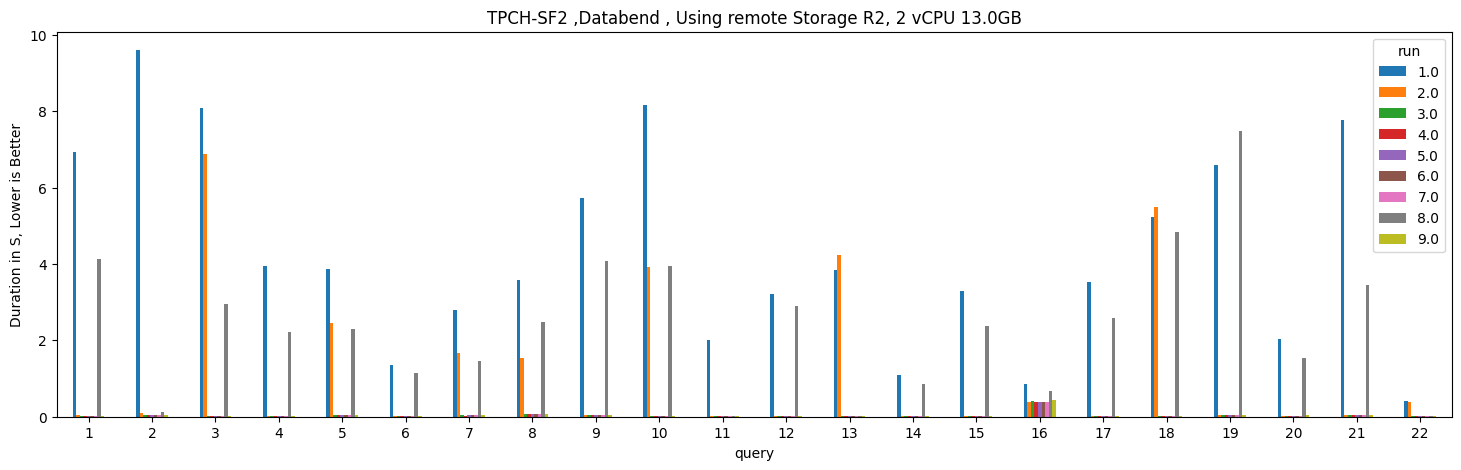

In [31]:
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = 'TPCH-SF'+str(sf)+' ,Databend , Using remote Storage R2, '+vCPU+' '+str(mem)+'GB'
import glob
databend = pd.concat(map(pd.read_csv, glob.glob('./result/*.csv')))
databend["run"] = databend.groupby("query")["runtime"].rank(method="first", ascending=True)
databend[['run','query','dur']]
df = databend.pivot(index='query', columns='run', values='dur')
ax = df.plot.bar(rot=0,title=runtime,ylabel='Duration in S, Lower is Better',figsize=(18,5))

# Disk Cache

In [22]:
%%time
ctx.sql("""
    select
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS qty1
    from lineitem
    group by 1,2
    """).collect()

CPU times: user 3.87 s, sys: 30 ms, total: 3.9 s
Wall time: 2.39 s


┌───────────────────────────────────────────────────┐
│ l_returnflag │ l_linestatus │         qty1        │
│  String NULL │  String NULL │ Decimal(38, 2) NULL │
├──────────────┼──────────────┼─────────────────────┤
│ 'R'          │ 'F'          │ 75577628.00         │
│ 'A'          │ 'F'          │ 75478173.00         │
│ 'N'          │ 'O'          │ 152954049.00        │
│ 'N'          │ 'F'          │ 1966480.00          │
└───────────────────────────────────────────────────┘

# Result Cache

In [12]:
%%time
ctx.sql("""
    select
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS qty
    from lineitem
    group by 1,2
    """).collect()

CPU times: user 5.45 ms, sys: 1.02 ms, total: 6.46 ms
Wall time: 9.35 ms


┌───────────────────────────────────────────────────┐
│ l_returnflag │ l_linestatus │         qty         │
│  String NULL │  String NULL │ Decimal(38, 2) NULL │
├──────────────┼──────────────┼─────────────────────┤
│ 'R'          │ 'F'          │ 75577628.00         │
│ 'A'          │ 'F'          │ 75478173.00         │
│ 'N'          │ 'O'          │ 152954049.00        │
│ 'N'          │ 'F'          │ 1966480.00          │
└───────────────────────────────────────────────────┘

# Delete Rows from a Table

In [13]:
%%time
ctx.sql(""" delete from customer where c_name = 'Customer#000128120' """).collect()

CPU times: user 760 ms, sys: 32.2 ms, total: 792 ms
Wall time: 6.01 s


┌┐
└┘

In [27]:
%%time
ctx.sql(""" delete from lineitem where l_returnflag = 'A' """).collect()

CPU times: user 35.4 s, sys: 2.13 s, total: 37.6 s
Wall time: 1min 7s


┌┐
└┘